# Specification

WARP is a 128-bit block cipher with a 128-bit key. The general structure of WARP is a variant of the 32-branch Type-2 GFN. A 128-bit plaintext $M$ and a ciphertext $C$ are loaded into a 128-bit internal state in encryption and decryption processes, respectively. The internal state is expressed as 32 nibbles, $X=X_0\|X_1\|\dots\|X_{31}$. A 128-bit secret key $K$ is denoted as two 64-bit keys $K^0$ and $K^1$, i.e. $K = K^0\|K^1$, $K^0$ and $K^1$ are also expressed as 16 nibbles, $K^0 = K^0_0\|K^0_1\|\dots\|K^0_{15}$, $K^1 = K^1_0\|K^1_1\|\dots\|K^1_{15}$.

The encryption process of WARP is as follows:

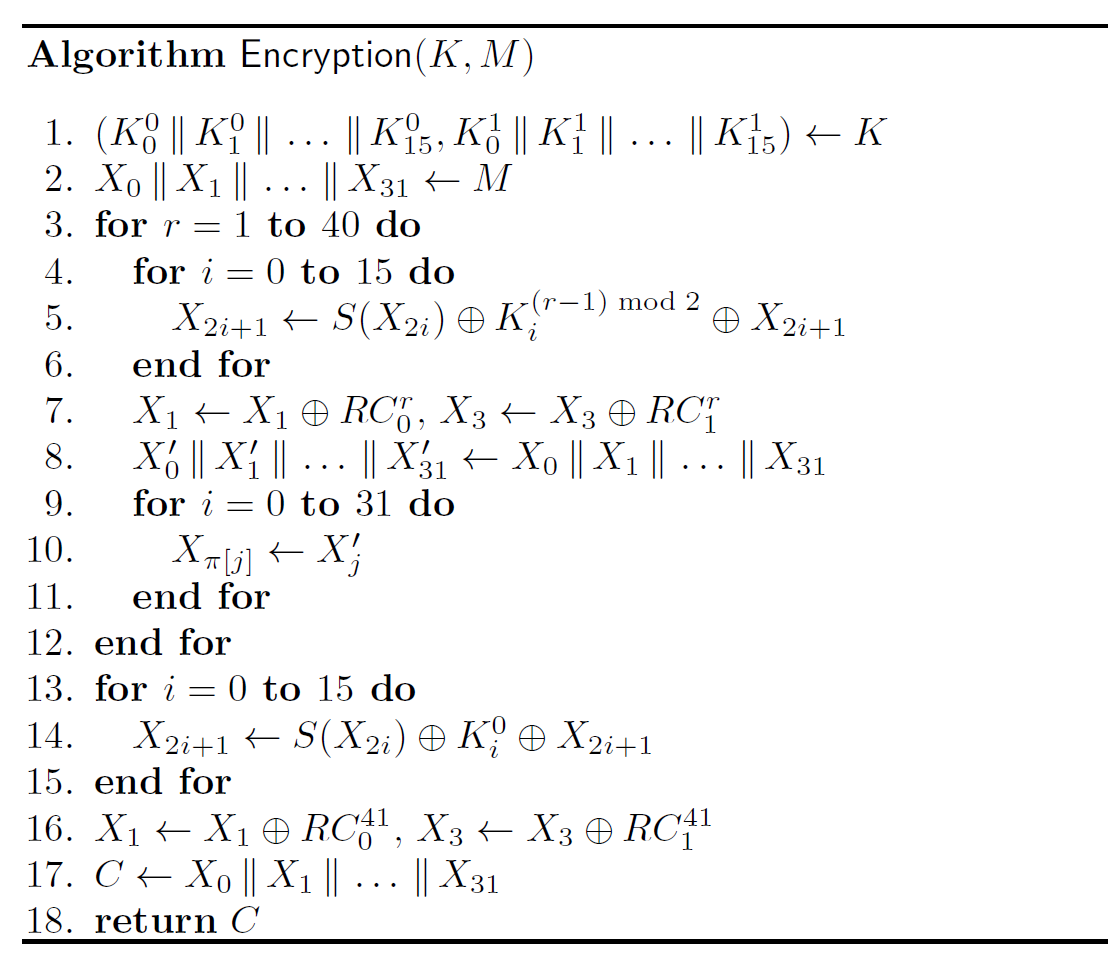

## Sbox

| x    | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | a | b | c | d | e | f |
|------|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| S(x) | c | a | d | 3 | e | b | f | 7 | 8 | 9 | 1 | 5 | 0 | 2 | 4 | 6 |

In [35]:
X = [i for i in range(0, 16)]
# MIDORI Sb_0
S = [0xC, 0xA, 0xD, 0x3, 0xE, 0xB, 0xF, 0x7, 0x8, 0x9, 0x1, 0x5, 0x0, 0x2, 0x4, 0x6]

## Shuffle $\pi$

| x  | 0  | 1 | 2  | 3  | 4 | 5  | 6  | 7 | 8  | 9 | 10 | 11 | 12 | 13 | 14 | 15 |
|----|----|---|----|----|---|----|----|---|----|---|----|----|----|----|----|----|
| $\pi$(x)  | 31 | 6 | 29 | 14 | 1 | 12 | 21 | 8 | 27 | 2 | 3  | 0  | 25 | 4  | 23 | 10 |
| $\pi^{-1}$(x) | 11 | 4 | 9  | 10 | 13| 22 | 1  | 30| 7  | 28| 15 | 24 | 5  | 18 | 3  | 16 |

| x  | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| $\pi$(x)  | 15 | 22 | 13 | 30 | 17 | 28 | 5  | 24 | 11 | 18 | 19 | 16 | 9  | 20 | 7  | 26 |
| $\pi^{-1}$(x) | 27 | 20 | 25 | 26 | 29 | 6  | 17 | 14 | 23 | 12 | 31 | 8  | 21 | 2  | 19 | 0  |

In [36]:
pi = [
    31,
    6,
    29,
    14,
    1,
    12,
    21,
    8,
    27,
    2,
    3,
    0,
    25,
    4,
    23,
    10,
    15,
    22,
    13,
    30,
    17,
    28,
    5,
    24,
    11,
    18,
    19,
    16,
    9,
    20,
    7,
    26,
]
pi_inv = [pi.index(i) for i in range(32)]


def shuffle(X, pi):
    Y = [0] * 32
    for i in range(32):
        Y[pi[i]] = X[i]
    return Y


X = [i for i in range(0, 32)]
Y = shuffle(X, pi)
X_ = shuffle(Y, pi_inv)
# validate
for r in range(32):
    # assert Y[r] == pi[r]
    assert X_[r] == X[r]

## Round constants $RC_i^r$

A state of 6-bit LFSR is written as $(l_5,l_4,l_3,l_2,l_1,l_0)$ and is initialized to 000001. It is updated in each round as:

$$
(l_5,l_4,l_3,l_2,l_1,l_0) = (l_4,l_3,l_2,l_1,l_0,l_0 \oplus  l_5) 
$$

Using this LFSR, we define two nibbles $RC^r_0$  = $(l_5,l_4,l_3,l_2)$ and $RC^r_1$ =
$(l_1,l_0,0,0)$.

| r  | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
|----|---|---|---|---|---|---|---|---|---|---|----|----|----|----|----|----|----|----|----|----|
| $RC^r_0$ | 0 | 0 | 1 | 3 | 7 | f | f | f | e  | d  | a  | 5  | a  | 5  | b  | 6  | c  | 9  | 3  | 6  | 
| $RC^r_1$  | 4 | c | c | c | c | c | 8 | 4 | 8 | 4  | 8  | 4  | c  | 8  | 0  | 4  | c  | 8  | 4  | c  |

| r  | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 | 30 | 31 | 32 | 33 | 34 | 35 | 36 | 37 | 38 | 39 | 40 | 41 |
|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| $RC^r_0$ | d  | b  | 7  | e  | d  | b  | 6  | d  | a  | 4  | 9  | 2  | 4  | 9  | 3  | 7  | e  | c  | 8  | 1  | 2  |
| $RC^r_1$ | c  | 8  | 4  | c  | 8  | 4  | 8  | 0  | 4  | 8  | 0  | 4  | c  | c  | 8  | 0  | 0  | 4  | 8  | 4  | c  |

In [37]:
RC0s = [
    0x0,
    0x0,
    0x1,
    0x3,
    0x7,
    0xF,
    0xF,
    0xF,
    0xE,
    0xD,
    0xA,
    0x5,
    0xA,
    0x5,
    0xB,
    0x6,
    0xC,
    0x9,
    0x3,
    0x6,
    0xD,
    0xB,
    0x7,
    0xE,
    0xD,
    0xB,
    0x6,
    0xD,
    0xA,
    0x4,
    0x9,
    0x2,
    0x4,
    0x9,
    0x3,
    0x7,
    0xE,
    0xC,
    0x8,
    0x1,
    0x2,
]

RC1s = [
    0x4,
    0xC,
    0xC,
    0xC,
    0xC,
    0xC,
    0x8,
    0x4,
    0x8,
    0x4,
    0x8,
    0x4,
    0xC,
    0x8,
    0x0,
    0x4,
    0xC,
    0x8,
    0x4,
    0xC,
    0xC,
    0x8,
    0x4,
    0xC,
    0x8,
    0x4,
    0x8,
    0x0,
    0x4,
    0x8,
    0x0,
    0x4,
    0xC,
    0xC,
    0x8,
    0x0,
    0x0,
    0x4,
    0x8,
    0x4,
    0xC,
]

len(RC0s) == len(RC1s) == 41 

True

## Encryption

$$K=0x0123456789ABCDEFFEDCBA9876543210$$
$$M=0x0123456789ABCDEFFEDCBA9876543210$$
$$C=0x24CE0A8EFD9F32DE529D5FDF45703A8D$$

In [38]:
# test vector
K0 = [i for i in range(0, 16)]
K1 = [i for i in range(15, -1, -1)]
M0 = [i for i in range(0, 16)] + [i for i in range(15, -1, -1)]
C0 = [
    0x2,
    0x4,
    0xC,
    0xE,
    0x0,
    0xA,
    0x8,
    0xE,
    0xF,
    0xD,
    0x9,
    0xF,
    0x3,
    0x2,
    0xD,
    0xE,
    0x5,
    0x2,
    0x9,
    0xD,
    0x5,
    0xF,
    0xD,
    0xF,
    0x4,
    0x5,
    0x7,
    0x0,
    0x3,
    0xA,
    0x8,
    0xD,
]
M1 = [0x0,0x0,0x1,0x1,0x2,0x2,0x3,0x3,0x4,0x4,0x5,0x5,0x6,0x6,0x7,0x7,0x8,0x8,0x9,0x9,0xA,0xA,0xB,0xB,0xC,0xC,0xD,0xD,0xE,0xE,0xF,0xF]
C1 = [0x9,0x2,0x3,0xC,0x6,0x4,0xF,0x9,0x2,0x8,0x2,0x7,0xE,0xE,0x6,0x2,0xB,0x9,0x6,0x6,0x7,0xD,0xD,0x2,0x5,0x4,0x8,0xF,0xB,0x1,0x2,0xC]

In [56]:
def format_X(X):
    return "".join([f"{x:1x}" for x in X])

0123456789abcdeffedcba9876543210


In [59]:

def warp_encrypt(M, K0, K1) -> list:
    X = M[:]
    # encryption
    # all round is 41
    # head 40 round
    for r in range(40):
        # print(f"round {r}")
        # sbox + add key + feistel
        # print(f"x = {format_X(X)}")
        for i in range(16):
            X[2 * i + 1] ^= S[X[2 * i]]
        # print(f"s = {format_X(X)}")
        for i in range(16):
            X[2 * i + 1] ^= (K0[i] if (r) % 2 == 0 else K1[i])
        # print(f"k = {format_X(X)}")
        X[1] = X[1] ^ RC0s[r]
        X[3] = X[3] ^ RC1s[r]
        # print(f"c = {format_X(X)}")
        X = shuffle(X, pi)
        # print(f"p = {format_X(X)}")

    # last round
    for i in range(16):
        X[2 * i + 1] = S[X[2 * i]] ^ K0[i] ^ X[2 * i + 1]
    X[1] = X[1] ^ RC0s[40]
    X[3] = X[3] ^ RC1s[40]
    return X


C = warp_encrypt(M0, K0, K1)
for r in range(32):
    assert C[r] == C0[r]
C = warp_encrypt(M1, K0, K1)
for r in range(32):
    assert C[r] == C1[r]